# Последовательные данные

Для анализа последовательных данных — звука, музыки, текста, температуры в Мюнхене, изменения цены биткоина, спортивной статистики, шахматных ходов, состояний игры в Доте — используются свои архитектуры, использующие «память» для обработки данных произвольной длины.

## Рекуррентные сети



Пусть у нас есть какая-нибудь функция от двух векторных аргументов $f(x, h)$ (нейросеть с trainable параметрами — тоже как бы функция) и какая-нибудь последовательость входных данных $\{x_1, x_2, \ldots, x_n\}$.

Получим последовательность $\{h_1, h_2, \ldots, h_n\}$ по следующему правилу: $ h_t = f(x_i, h_{t-1}) $ ($h_0$ предполагаем чем-нибудь изначально инициализированным). Все осталньые $h_i$ будут потом использоваться для чего-то полезного.

Когда мы это всё развернем, на самом деле получится обычный статический вычислительный граф, выходом которого будет $n$ скрытых состояний.

![RNN](https://i.stack.imgur.com/hzZ4m.png)

Подобные архитектуры и называют рекуррентными сетями.

# «Затухающий градиент»

**В чём проблема**. Мы знаем, что глубокие сети очень трудно обучать. Рекуррентная сеть по сути не отличается от очень глубокой статичной сети, данные которой вставляются в разные уровни глубины. С такой архитектурой будет очень трудно уловить связь, например, между данными на начале последовательности и целевой функцией.

**LSTM**. Чтобы с этим побороться, придумали различные механизмы памяти. 

Представьте конвейерную ленту, которая движется вдоль наших последовательных данных. Информация с данных может запрыгивать на ленту, проезжать вперед и спрыгивать оттуда, когда она понадобится. LSTM (long-short term memory) — это тот блок, который решает, какой информации нужно запрыгнуть. Он позволяет сохранять информацию для более позднего времени, когда она понадобится.

Он состоит из нескольких «гейтов», каждый из которых представляет собой trainable матрицу, которые решают, что можно забыть, что можно добавить, и что сейчас в данный момент важно от входных данных. Эти гейты считают маски — вектора после softmax — на которые домножаются входные данные.

![lstm](images/lstm.png)

Эту LSTM-ячейку мы просто будем использовать в качестве $f$. Суть не изменилась: граф также разворачивается в статический, только более сложный.

![LSTM](https://cdn-images-1.medium.com/max/2000/1*S0Y1A3KXYO7_eSug_KsK-Q.png)

# Эмбеддинги

Рассмотрим задачу классификации текстов по их темам (тематическое моделирование).

Нейросети не берут на вход сырые текстовые данные, а работают с векторами. Как правило, текст разделяют (*токенизируют*) на мелкие куски (буквы, слова, отдельные слоги), а дальше каждый токен заменяется на one-hot вектор размерности словаря.

Но что будет, если помножить one-hot вектор на матрицу? Получится просто какая-то строка матрицы. Вместо этой операции можно сразу вставить строку, соответствующую единичке. Эта концепция называется embedding — теперь каждому токену ассоциирован его вектор.

**Word2vec**. У этих векторов есть смысл и много применений. В них даже работает всякая алгебра типа «король - мужчина + женщина = королева». Синонимы должны иметь очень близкие вектора.

![word2vec](images/word2vec.png)

Впрочем, геометрическая интерпретация пока не нашла особых применений.

Зацените ещё эту игру: https://research.google.com/semantris

word2vec, glove, fasttext — это все эмбеддинги, только посчитанные разными алгоритмами на разных задачах.

# Пишем код

Типичный пайплайн в NLP такой:

* Токенизировать данные
* Сконвертировать в вектора
* Написать модель и зафитить
* Сконвертировать обратно (если мы генерируем тоже текст)

Только третий пункт относится к DL, остальное тоже нужно сделать, но не сейчас. В примере данные уже будут токенизированы за нас.

Есть такой сайт, как IMDB — пиндосский кинопоиск. На нём есть отзывы к фильмам, которые бывают положительные и отрицательные. Мы хотим научиться из классифицировать на эти два класса, не зная лейбл, а только сам текст отзыва.

In [0]:
from keras.preprocessing import sequence
from keras.datasets import imdb

# нужно как-то ограничить число токенов
# редкие токены будут объединены в один токен <unk>
vocab_size = 10000
embedding_dim = 50 # вектор этого размера будет ассоциирован с каждым 

(X, y), _ = imdb.load_data(num_words=vocab_size)

Камень в сторону фреймворков, строящих статический вычислительный граф (Keras относится к ним): оно на практике реализовано так, как на первой картинке: просто все разворачивается в один длинный граф с расшаренными весами. Это дает такое ограничение: внутри батча все данные должны быть одной длины. Даже если у нас есть очень короткие предложения, их нужно дополнить специальными токенами до некоторой константы maxlen. Многие операции будут считаться впустую, но ничего с этим нам пока не поделать.

Подберем правильный maxlen:

467.0


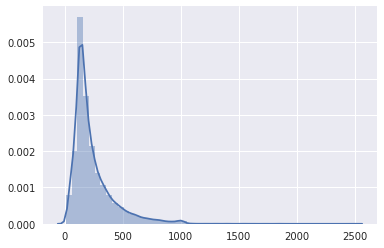

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

lens = [len(x) for x in X]
sns.distplot(lens)
print(np.percentile(lens, 90))

Можем выбрать в качестве этого параметра что-то около 500. Это покроет более 90% примеров, и это хороший trade-off между потерей информации и скоростью работы.

In [0]:
maxlen = 500
X = sequence.pad_sequences(X, maxlen=maxlen)

In [0]:
from keras.layers import LSTM, Dense, Embedding
from keras.models import Sequential

RNN = Sequential([
    Embedding(vocab_size, embedding_dim), # эта шняга тупо переводит int-ы соответствующие вектора
    LSTM(embedding_dim), # lstm, примененный к векторизованной последовательности
    # вернет свое итоговое состояние
    Dense(1, activation='sigmoid')
])

RNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 520,251
Trainable params: 520,251
Non-trainable params: 0
_________________________________________________________________


In [0]:
RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = RNN.fit(X, y, epochs=5, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/5
22500/22500 [==============================] - 1585s - loss: 0.4982 - acc: 0.7549 - val_loss: 0.3985 - val_acc: 0.8244
Epoch 2/5
22500/22500 [==============================] - 1713s - loss: 0.2828 - acc: 0.8903 - val_loss: 0.3320 - val_acc: 0.8768
Epoch 3/5
22500/22500 [==============================] - 286s - loss: 0.2364 - acc: 0.9079 - val_loss: 0.3665 - val_acc: 0.8424
Epoch 4/5
22500/22500 [==============================] - 327s - loss: 0.2279 - acc: 0.9088 - val_loss: 0.4192 - val_acc: 0.8672
Epoch 5/5
22500/22500 [==============================] - 368s - loss: 0.1400 - acc: 0.9511 - val_loss: 0.4796 - val_acc: 0.7960


# Transfer Learning

Если вы поизучали то, что вернул .summary(), то могли заметить, что большинство параметров — сами embedding-и, и в основном на их обучение уходит время.

Так же как и с CNN, где мы «крали» веса с начальных слоев, здесь мы можем сделать то же самое, украв embedding-и у более основательно подошедших к этому людей.

Обычно эти шняги распространяют в формате «слово в unicode и 300 флоатов через пробел».

In [0]:
with open('glove.vec') as file:
    for line in file:
        l = line.split()
        word = l[0]
        vec = np.array([float(x) for x in l[1:]])
        embeddings += [vec]
embeddings = np.stack(embeddings)

Теперь можно указать для слоя Embedding, откуда брать веса, через `weights=[embeddings]` и зафризить через trainable=False. Весь Transfer Learning делается примерно так. Правда, иногда не размораживают после какой-то эпохи.

# Свёрточные сети для последовательностей

Как бы мы обрабатываем последовательности произвольной длины, но и как бы нет. Можно фиксировать длину предложения и попробовать уже известные архитектуры.

Для некоторых задач — например, распознования речи, — свёрточные сети могут быть даже лучше. Загуглите WaveNet.

In [0]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout

TextCNN = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embeddings], input_length=maxlen, trainable=False),
    Conv1D(32, 7, activation='relu', padding='same'),
    MaxPooling1D(2),
    Conv1D(64, 7, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

TextCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 50)           500000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           11232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 250, 64)           14400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
__________

# Как правильно делать токенизацию

Токенизация — это всегда головная боль. Её кодить не сложно, но муторно, и поэтому было написано дофига библиотек, которые это делают. В частности, какие-то токенизаторы есть и в Keras.

In [0]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10)
tokenizer.fit_on_texts('гыгыгы')
tokenized = tokenizer.texts_to_sequences('азаза')